In [1]:
# Hypotheses
# Discount vs Quantity
# Hire Date of employee vs Total Revenue per employee (need to pick 1 year - current?)
# Region vs Revenue (need to pick 1 year - current)
# Seasonality vs Revenue (based on seasons in US - 4 seasons)

# Module 3 Project - Hypothesis Testing

The purpose of this project is to identify ways to improve the business of Northwind, a fictional company by asking 4 important questions and answering them via hypothesis testing. These 4 questions are - 

1. Does discount increase the quantity of product in an order?
2. Does seasonality have an impact on revenue?
3. Does region of business have an impact on revenue?
4. Does the choice of shipping company have an impact on the freight cost? 

Before, we begin the hypothesis testing, we first need to obtain the data, scrub the data and add necessary data.

# Obtaining Data - Using SQL to create the Dataframe

My first step is import various tools that are required for this project -

In [2]:
import sqlite3
import pandas as pd
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

The next step is to perform a SQL query in order to pull necessary data from the northwind sqlite database and create a dataframe. The data I will pull from the sqlite database are -

- Order ID
- Product ID
- Unit Price
- Discount Percentage
- Order Date
- Regions

I am pulling these specific data because they are important for the hypothesis testings that I will be performing later. After that, I will create a dataframe.

In [3]:
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
# joining sql tables and selecting data columns

cur.execute(""" SELECT od.ID, od.ProductID, od.UnitPrice, od.Quantity, od.Discount, o.OrderDate, e.Title, 
                r.RegionDescription, s.CompanyName, o.Freight
                FROM 'Order' o
                JOIN 'OrderDetail' od
                ON od.OrderID = o.ID
                JOIN Employee e
                ON o.EmployeeID = e.ID
                JOIN EmployeeTerritory as et
                ON e.ID = et.EmployeeID
                JOIN Territory as t
                ON et.TerritoryID = t.ID
                JOIN Region as r
                ON t.RegionID = r.ID
                JOIN Shipper s
                ON o.ShipVia = s.ID
                GROUP BY od.ID
                """)

In [5]:
# creating a dataframe from the sql query

df = pd.DataFrame(cur.fetchall())


In [6]:
# adding the dataframe columns
 
df.columns = [x[0] for x in cur.description]

# Scrubbing the Dataframe

My next step is to check the dataframe that I just created and see if there are any missing value or filler values in each column.

In [7]:
# checking the data

df.head()

,Id,ProductId,UnitPrice,Quantity,Discount,OrderDate,Title,RegionDescription,CompanyName,Freight
0,10248/11,11,14.0,12,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38
1,10248/42,42,9.8,10,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38
2,10248/72,72,34.8,5,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38
3,10249/14,14,18.6,9,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61
4,10249/51,51,42.4,40,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61


In [8]:
# checking the missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 10 columns):
Id                   2155 non-null object
ProductId            2155 non-null int64
UnitPrice            2155 non-null float64
Quantity             2155 non-null int64
Discount             2155 non-null float64
OrderDate            2155 non-null object
Title                2155 non-null object
RegionDescription    2155 non-null object
CompanyName          2155 non-null object
Freight              2155 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 168.5+ KB


In [9]:
# checking missing values

df.isna().sum()

Id                   0
ProductId            0
UnitPrice            0
Quantity             0
Discount             0
OrderDate            0
Title                0
RegionDescription    0
CompanyName          0
Freight              0
dtype: int64

It looks like each column has 40516 entries. Therefore, there are no missing or null values.

In [10]:
#checking the top 5 values in each column

for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n' )

Id 
 11034/44    0.000464
10938/60    0.000464
10701/71    0.000464
10490/75    0.000464
10964/69    0.000464
Name: Id, dtype: float64 


ProductId 
 59    0.025058
31    0.023666
24    0.023666
60    0.023666
56    0.023202
Name: ProductId, dtype: float64 


UnitPrice 
 18.0    0.047332
10.0    0.032947
14.0    0.025986
12.5    0.025522
19.0    0.024594
Name: UnitPrice, dtype: float64 


Quantity 
 20    0.116937
30    0.090023
10    0.083991
15    0.078422
40    0.052436
Name: Quantity, dtype: float64 


Discount 
 0.00    0.611137
0.05    0.085847
0.10    0.080278
0.20    0.074710
0.15    0.072854
Name: Discount, dtype: float64 


OrderDate 
 2014-05-06    0.014849
2014-02-26    0.007425
2014-04-06    0.006497
2014-03-26    0.006497
2014-04-17    0.006497
Name: OrderDate, dtype: float64 


Title 
 Sales Representative        0.713225
Inside Sales Coordinator    0.120650
Vice President, Sales       0.111833
Sales Manager               0.054292
Name: Title, dtype: float64 


RegionDes

Based on the top 5 values with the highest number in each column, there is no filler or placeholder values with a large population.

Next, I will look at how many unique values are in each column.

In [11]:
# checking number of unique values

for col in df.columns:
    print(col, '\n', len(df[col].unique()))

Id 
 2155
ProductId 
 77
UnitPrice 
 116
Quantity 
 55
Discount 
 11
OrderDate 
 480
Title 
 4
RegionDescription 
 4
CompanyName 
 3
Freight 
 799


As per the unique values, there are 11 different percentages of discount. This number seems a little high. I will find out what are these percentages and how many records each percentage has.

In [12]:
# Checking what are the unique discount percentages and how many records each percentage has

discounts = df['Discount'].unique()
discounts.sort()

for i in range(len(discounts)):
    
    discount = discounts[i]
    s1 = df[df['Discount']== discount]['Quantity']
    print("{}:  ".format(discount), len(s1))

0.0:   1317
0.01:   1
0.02:   2
0.03:   3
0.04:   1
0.05:   185
0.06:   1
0.1:   173
0.15:   157
0.2:   161
0.25:   154


Based on the above information, discount 1%, 2%, 3%, 4% and 6% have very small number of entries. Most of them only have 1 entry. This is not a good sample size for our hypothesis testing and they could even be errors in the database. Therefore, I will change these discount percentages as 5%.

In [13]:
# changing the 1%, 2%, 3%, 4% and 6% discounts as 5%

x = [0.01, 0.02, 0.03, 0.04, 0.06]

for i in x:
    df['Discount'][df['Discount']== i] = 0.05

In [14]:
discounts = df['Discount'].unique()
discounts.sort()

for i in range(len(discounts)):
    
    discount = discounts[i]
    s1 = df[df['Discount']== discount]['Quantity']
    print("{}:  ".format(discount), len(s1))

0.0:   1317
0.05:   193
0.1:   173
0.15:   157
0.2:   161
0.25:   154


Next, I will check if any of the column has outliers.

In [15]:
#checking outliers

df.describe()

,ProductId,UnitPrice,Quantity,Discount,Freight
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,40.793039,26.218520,23.812993,0.056241,96.197726
std,22.159019,29.827418,19.022047,0.083431,133.011272
min,1.000000,2.000000,1.000000,0.000000,0.020000
25%,22.000000,12.000000,10.000000,0.000000,19.610000
50%,41.000000,18.400000,20.000000,0.000000,53.800000
75%,60.000000,32.000000,30.000000,0.100000,120.920000
max,77.000000,263.500000,130.000000,0.250000,1007.640000


Based on the description of the dataframe, the Unit Price and Quantity columns seem to have outliers which are extremely higher than the 75th percentiles. These outliers might impact our hypothesis testing. However, I will not remove them for now as I will handle them as I go through each hypothesis test.

# Modifying the Dataframe

As the next step, I will add the revenue column to the dataframe by calculating the discounted price (unit price * (1 - discount percentage)) and multiplying that price with the quanity in an order. This revenue data will be used for my 2nd, 3rd and 4th hyopthesis tests.

Before adding the revenue column, let's check if discount has been already applied to the unit price. We will do this by picking Product ID 11 and compare the unit prices for the orders with discount and the orders without discount.

In [16]:
# Creating a subset with product id 11

df1 = df[df['ProductId']==11]

df1.head()

,Id,ProductId,UnitPrice,Quantity,Discount,OrderDate,Title,RegionDescription,CompanyName,Freight
0,10248/11,11,14.0,12,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38
129,10296/11,11,16.8,12,0.0,2012-09-03,Sales Representative,Western,Speedy Express,0.12
209,10327/11,11,16.8,50,0.2,2012-10-11,"Vice President, Sales",Eastern,Speedy Express,63.36
280,10353/11,11,16.8,12,0.2,2012-11-13,Sales Representative,Western,Federal Shipping,360.63
313,10365/11,11,16.8,24,0.0,2012-11-27,Sales Representative,Southern,United Package,22.00


The 2nd and 3rd rows of the above dataframe have the same unit price of 16.8. However, the discount for 2nd row is 0.0 whereas the discount for the 3rd row is 0.2 or 20%. Based on this, we can conclude that the unit price is the pre-discount price. 

So, we can go ahead and apply the discount to the unit price and multiply it with the quantity in order to calculate the revenue.

In [17]:
#adding revenue column

df['Revenue'] = (df['UnitPrice'] * (1 - df['Discount'])) * df['Quantity']

# checking if the newly added column is there

df.head()

,Id,ProductId,UnitPrice,Quantity,Discount,OrderDate,Title,RegionDescription,CompanyName,Freight,Revenue
0,10248/11,11,14.0,12,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,168.0
1,10248/42,42,9.8,10,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,98.0
2,10248/72,72,34.8,5,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,174.0
3,10249/14,14,18.6,9,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,167.4
4,10249/51,51,42.4,40,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,1696.0


I will also add another column - the season in which the order took place. I need this seasonality data for my 4th hypothesis testing. These are US seasons and they are - 

Spring: 1 March to 31 May

Summer: 1 June to 31 August

Autumn: 1 September to 30 November

Winter: 1 December to 28 February

To create this season column based on the Order Date column, I will -

1. Divide the month of order by 12 and find the remainder by using the modulo operator
2. Add 3 to the result of 1st step
3. Peform floor division to the result of 2nd step by 3
4. Based on the result, seasons will be assigned (i.e. 1 = Winter, 2 = Spring, 3 = Summer, 4 = Autum).

In [18]:
#adding season column

df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Season'] = (df['OrderDate'].dt.month%12 + 3)//3

df['Season'][df['Season']== 1] = 'Winter'
df['Season'][df['Season']== 2] = 'Spring'
df['Season'][df['Season']== 3] = 'Summer'
df['Season'][df['Season']== 4] = 'Autumn'

In [19]:
# checking if the season column has been added

df.head()

,Id,ProductId,UnitPrice,Quantity,Discount,OrderDate,Title,RegionDescription,CompanyName,Freight,Revenue,Season
0,10248/11,11,14.0,12,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,168.0,Summer
1,10248/42,42,9.8,10,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,98.0,Summer
2,10248/72,72,34.8,5,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,174.0,Summer
3,10249/14,14,18.6,9,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,167.4,Summer
4,10249/51,51,42.4,40,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,1696.0,Summer


Next, I will add the average freight column by dividing the freight by the quantity. I need this column for my fourth hypothesis testing.

In [20]:
#adding average freight column

df['Avg_Freight'] = (df['Freight'])/(df['Quantity'])

In [21]:
# checking if the average freight column has been added

df.head()

,Id,ProductId,UnitPrice,Quantity,Discount,OrderDate,Title,RegionDescription,CompanyName,Freight,Revenue,Season,Avg_Freight
0,10248/11,11,14.0,12,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,168.0,Summer,2.698333
1,10248/42,42,9.8,10,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,98.0,Summer,3.238000
2,10248/72,72,34.8,5,0.0,2012-07-04,Sales Manager,Eastern,Federal Shipping,32.38,174.0,Summer,6.476000
3,10249/14,14,18.6,9,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,167.4,Summer,1.290000
4,10249/51,51,42.4,40,0.0,2012-07-05,Sales Representative,Western,Speedy Express,11.61,1696.0,Summer,0.290250


Now that I have the dataframe with the columns I need, I will begin to perform hypothesis testing.

# Hypothesis Testing - Discount Vs Quantity

The first hypothesis testing that I will perform is to answer the following questions- 

###### 1. Does discount amount have a statistically significant effect on the quantity of a product in an order?
###### 2. If so, at what level(s) of discount?

To answer the first question, I will form the following two-tailed null and alternative hypotheses - 

$H_{0}$ : The mean difference of quantity ordered between the orders without discount and the orders with discount is zero. ($\mu_{0} >= \mu_{1}$) 

$H_{1}$ : The mean difference of quantity ordered between the orders without discount and the orders with discount is larger than zero. ($\mu_{0} < \mu_{1}$)

Before going into the hypothesis testing, let's divide the 'Quantity' data into two subsets - one with the quantity of product in an order that has discount and one without discount.

Next, we will look at the distribution of each subset and see if they follow the normal distribution. We will do this by -

1. Looking the distribution plots of each subset
2. Checking the p-value of normal test from scipy.stats by comparing the subset against a normal distribution. We will use $\alpha$ or the threshold value as 0.05. If the resulting p-value is less than 0.05, we will reject the null hypothesis that the data is normall distributed.

In [22]:
# Creating two subsets of Quantity based on whether discount is applied or not

no_discount = df[df['Discount']==0.0]['Quantity']
discount = df[df['Discount']!=0.0]['Quantity']

In [23]:
# checking if the two subsets add up to the total count

print(len(no_discount))
print(len(discount))
print(len(no_discount)+len(discount))

1317
838
2155


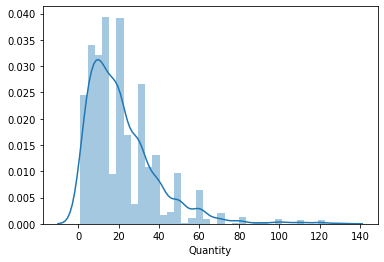

In [24]:
# Checking the distribution plot of no_discount

sns.distplot(no_discount)

In [25]:
st.normaltest(no_discount)

NormaltestResult(statistic=544.5770045551499, pvalue=5.579637380546921e-119)

The distribution plot of the subset 1 shows that it is right skewed. The p-value from the normal test is also less than 0.05. Therefore, we now know that the data of subset 1 is not normally distributed.

Now, let's check subset2.

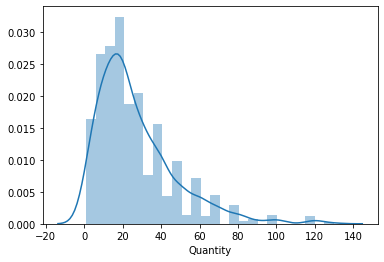

In [26]:
sns.distplot(discount)

In [27]:
st.normaltest(discount)

NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)

Similar to subset 1, the distribution plot of subset 2 also shows that it is right skewed. In addition, its p-value from the normal test is also less than 0.05. So, we can also conclude that subset 2 does not follow a normal distribution as well.

Since both subsets are non-normal, I will apply the central limit theorem and create sampling distributions for both subsets. I will do this by -

1. Write a helper function to take a random sample with sample size = n
2. Write a helper function to calculate the mean of the sample from step 1
3. Write a function that utilizes the previous 2 help functions to create a sampling distribution
4. Create a sampling distribution from 1000 samples with the sample size of 30. I am choosing the sample size of 30 because as per the Central Limit Theorem, the sampling distribution becomes normal on average at this sample size.

In [28]:
# Writing a function to take a random sample with sample size = n

def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

In [29]:
# Writing a function to calculate the sample mean

def get_sample_mean(sample):
    return sum(sample) / len(sample)

In [30]:
# Writing a function to create the sampling distribution

def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [31]:
# Creating the sampling distribution from no_discount

no_discount_sample = create_sample_distribution(no_discount, 1000, 30)

Now, let's check the normality of the subset 1's sampling distribution - 

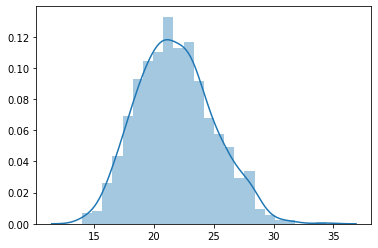

In [32]:
# Checking the distribution plot of no_discount's sampling distriubtion

sns.distplot(no_discount_sample)

In [33]:
# Calculating the p-value of no_discount's sampling distriubtion

st.normaltest(no_discount_sample)

NormaltestResult(statistic=14.421696683856824, pvalue=0.000738530363360756)

The distribution plot of subset 2's sampling distribution is more or less normal. However, the p-value from the normal test is still less than 0.05.

Let's move on to subset 2 -

In [34]:
# Creating the sampling distribution from discount

discount_sample = create_sample_distribution(discount, 1000, 30)

Next, I will check the normality of subset 2's sampling distribution - 

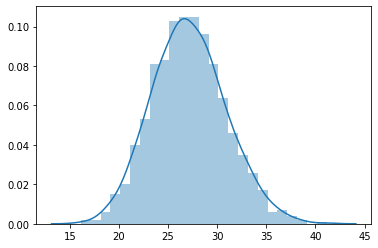

In [35]:
# Checking the distribution plot of discount's sampling distriubtion

sns.distplot(discount_sample)

In [36]:
# Calculating the p-value of discount's sampling distriubtion

st.normaltest(discount_sample)

NormaltestResult(statistic=7.4014939884034705, pvalue=0.024705065035570423)

Similar to the sampling distribution of subset 1, the sampling distribution of subset 2 also look normal based on the plot. But, the p-value from the normal test is less than 0.05.

The low p-values of both subset 1 and 2 is due to the large distribution size 1000. With larger datasets, the goodness-of-fit test can become very sensitive to a small deviation from the distributions that it is trying to fit. In this case, the larger the subsets, our normal test will show significant p-values (values less than 0.05) when the sampling distribution of the subsets deviate slightly from the normal distributon.

To check this, let's create sampling distributions from the subsets with smaller distribution sizes - 10 and 100. 

In [37]:
# Creating test sampling distribution from no_discount 

no_discount_10 = create_sample_distribution(no_discount, 10, 30)
no_discount_100 = create_sample_distribution(no_discount, 100, 30)

# Printing the normal test p-values

print(st.normaltest(no_discount_10))
print(st.normaltest(no_discount_100))

NormaltestResult(statistic=1.0391553714917074, pvalue=0.5947716754956196)
NormaltestResult(statistic=8.167838660930943, pvalue=0.016841329397060248)


In [38]:
# Creating test sampling distribution from discount

discount_10 = create_sample_distribution(discount, 10, 30)
discount_100 = create_sample_distribution(discount, 100, 30)

# Printing the normal test p-values

print(st.normaltest(discount_10))
print(st.normaltest(discount_100))

NormaltestResult(statistic=3.4776141992480376, pvalue=0.17572990390231544)
NormaltestResult(statistic=0.3936879829633972, pvalue=0.8213187560404627)


The resulting p-values for both 10 and 100 distribution sizes are larger than the threshold of 0.05.

Since, we cannot rely soley on the p-value to test the normal distribution, we will just use the distribution plots and continue with the hypothesis testing if the plots display normality.

Now that we have two sampling distributions that more or less follow the normal distribution, we can begin testing between these two groups.

The important thing to decide now is which test we should use to test the groups. Since we do not have the entire population of the order data, we cannot use the z-test since it assumes that we know the population mean.

If we want to use the t-test, we must first check if our datasets meets its two required assumptions - 

1. The two groups have equal size.
2. The two groups have equal variance.

Since we use 1000 as the sampling distribution size, we know that the two groups have equal size. Now, let's check if the two groups' variances are equal by using Levene's test -

In [39]:
# Checking if the groups have equal variance

st.levene(no_discount_sample, discount_sample, center='mean')

LeveneResult(statistic=20.987652061967545, pvalue=4.907719340821148e-06)

Looks like the two groups have unequal variances. Therefore, we will not use the t-test. Instead, we will use the Welch's t-test since it allows unequal variances of the two groups.

To use the Welch's t-test, I will perform the following steps -

1. Write a helper function to calculate the t-value
2. Write a helper function to calculate the degree of freedom or df
3. Write a function that utilizes the two helper functions to calculate the p-value

In [40]:
# Writing a helper function to calculate the Welch's t-value

def welch_t(a, b):

    numerator = np.mean(a) - np.mean(b)
    
    denominator = np.sqrt((np.var(a, ddof=1)/len(a)) + (np.var(b, ddof=1)/len(b)))
    
    return np.abs(numerator/denominator)


In [41]:
# Writing a helper function to calculate the Welch's df

def welch_df(a, b):
    
    s1 = np.var(a, ddof=1) 
    s2 = np.var(b, ddof=1)
    n1 = len(a)
    n2 = len(b)
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


In [42]:
# Writing a function to calculate the Welch's p-value

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-st.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

Now that I have the function to perform the Welch's t-test, let's test the two groups and calculate the p-value. I will also calculate the medians and means of the two groups to compare.

In [43]:
print("Median Values: \ts1: {} \ts2: {}".format(round(np.median(no_discount_sample), 2), round(np.median(discount_sample), 2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(np.mean(no_discount_sample), 2), round(np.mean(discount_sample), 2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(no_discount_sample), len(discount_sample)))
print("Welch's t-test p-value:", p_value(no_discount_sample, discount_sample, two_sided=True))

Median Values: 	s1: 21.57 	s2: 27.0
Mean Values: 	s1: 21.78 	s2: 27.14
Sample sizes: 	s1: 1000 	s2: 1000
Welch's t-test p-value: 0.0


Since the p-value we get from the Welch's t-test 0.0 and less than the threshold value of 0.05, we can reject the null hypothesis that the mean difference of quantity ordered between the orders without discount and the orders with discount is zero.

Just to be safe, we previously found out that the quantity columns have outliers that are a lot higher than its 75th percentile. These outliers might influence our testing and give us an incorrect p-value. So, let's run the Welch's t-test again but this time without the outliers.

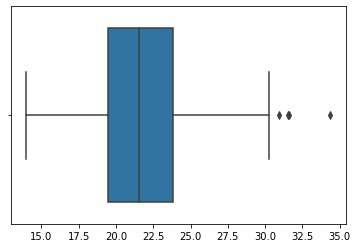

In [44]:
# Checking the boxplot of s1_sample to detect outliers

sns.boxplot(no_discount_sample)

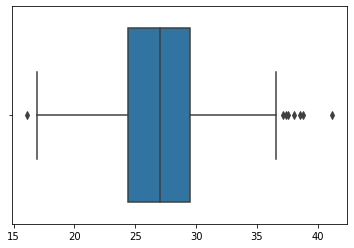

In [45]:
# Checking the boxplot of s2_sample to detect outliers

sns.boxplot(discount_sample)

By looking at the boxplots, we can confirm that there are outliers in both groups, especially in the higher ends. Now, let's remove these outliers by writing a function that calculate each group's lower range and upper range, and remove the values that are higher or lower than these ranges.

In [46]:
# Writing a function to remove outliers

def remove_outliers(s):
    Q1 = np.quantile(s, q=0.25)
    Q3 = np.quantile(s, q=0.75)
    IQR = Q3 - Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+(1.5*IQR)
    
    s_test = []
    
    for i in s:
        if lower_range <= i <= upper_range:
            s_test.append(i)
        else:
            continue
    
    return s_test

In [47]:
# Removing outliers from s1_sample

no_discount_no_outliers = remove_outliers(no_discount_sample)

# Checking if the outliers have been removed

len(no_discount_no_outliers)

996

In [48]:
# Removing outliers from s2_sample

discount_no_outliers = remove_outliers(discount_sample)

# Checking if the outliers have been removed

len(discount_no_outliers)

992

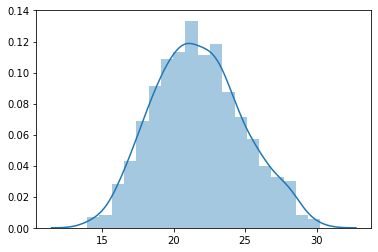

In [49]:
# Reviewing the distribution plots

sns.distplot(no_discount_no_outliers)

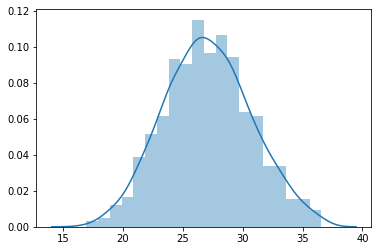

In [50]:
# Reviewing the distribution plots

sns.distplot(discount_no_outliers)

Looks like the long tails of the distribution plots are now gone. We can begin performing the Welch's t-test now.

In [51]:
# Re-running the Welch's t-test and printing out the values

print("Median Values: \ts1: {} \ts2: {}".format(round(np.median(no_discount_no_outliers), 2), round(np.median(discount_no_outliers), 2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(np.mean(no_discount_no_outliers), 2), round(np.mean(discount_no_outliers), 2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(no_discount_no_outliers), len(discount_no_outliers)))
print("Welch's t-test p-value:", p_value(no_discount_no_outliers, discount_no_outliers, two_sided=True))

Median Values: 	s1: 21.53 	s2: 27.0
Mean Values: 	s1: 21.74 	s2: 27.07
Sample sizes: 	s1: 996 	s2: 992
Welch's t-test p-value: 0.0


We get the same p-value even when the outliers are removed. So, the outliers were not affecting our test and we can conclude that the discount has an impact on the quantity of products in an order.

Next, we will check what level of discounts significantly impact the quantity of products in an order. To find out about this, we need to -

1. Divide the quantity data into subsets based on different discount level.
2. Create a sampling distribution group from each subset in order to make the distribution normal.
3. Remove outliers from each group so that the outliers won't impact our testing.
4. Perform Welch t-test between a group with a discount percentage and another group with one level higher discount percentage. For example, the test will be performed between 0% discount group and 5% discount group. If we continue to test this way, we might be able to find a discount level that does not significantly influence the quantity of products in an order. In these tests, we will continue to use the threshold value of 0.05.


In [52]:
# Dividing the data into subsets

zero = df[df['Discount']==0.0]['Quantity']
five = df[df['Discount']==0.05]['Quantity']
ten = df[df['Discount']==0.1]['Quantity']
fifteen = df[df['Discount']==0.15]['Quantity']
twenty = df[df['Discount']==0.2]['Quantity']
twenty_five = df[df['Discount']==0.25]['Quantity']

Now, let's check if each group follows a normal distribution.

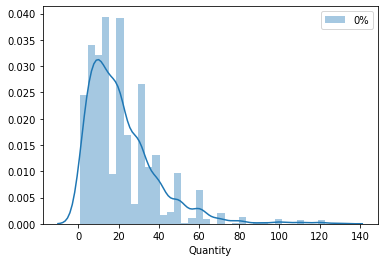

NormaltestResult(statistic=544.5770045551499, pvalue=5.579637380546921e-119)
-------------------------------------------------------------------------------------


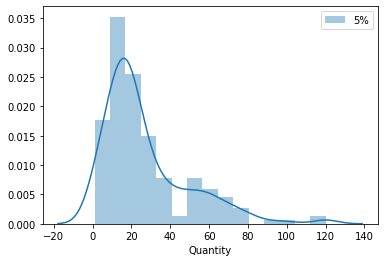

NormaltestResult(statistic=65.2507492701047, pvalue=6.776100302540496e-15)
-------------------------------------------------------------------------------------


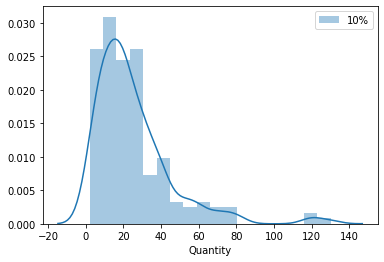

NormaltestResult(statistic=98.50271035413209, pvalue=4.0776337983848464e-22)
-------------------------------------------------------------------------------------


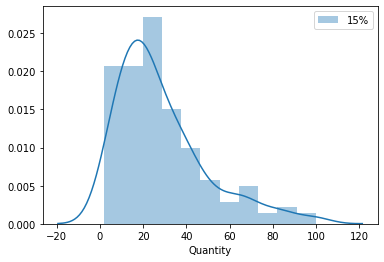

NormaltestResult(statistic=38.52550343019272, pvalue=4.308173885400061e-09)
-------------------------------------------------------------------------------------


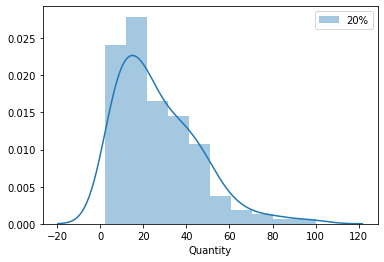

NormaltestResult(statistic=31.398997154435623, pvalue=1.519827852850104e-07)
-------------------------------------------------------------------------------------


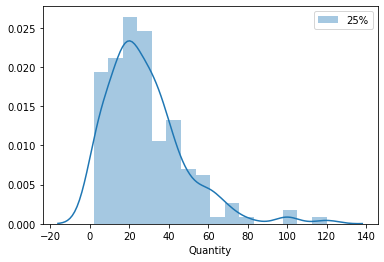

NormaltestResult(statistic=54.44887806745976, pvalue=1.5016763972075847e-12)
-------------------------------------------------------------------------------------


In [53]:
# Checking the distribution plot and normal test of each group

discounts = [zero, five, ten, fifteen, twenty, twenty_five]
discount_names = ['0%', '5%', '10%', '15%', '20%', '25%']

for i in range(len(discounts)):

    sns.distplot(discounts[i], label=discount_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(discounts[i]))
    print ("-------------------------------------------------------------------------------------")

Based on the distribution plots and the p-values of the normal tests, we can conclude that the datasets are far from normal. So, I will create a sampling distribution for each group by using 1000 as the distribution size and 30 as the sample size.

In [54]:
# Creating sampling distributions

zero = create_sample_distribution(zero, 1000, 30)
five = create_sample_distribution(five, 1000, 30)
ten = create_sample_distribution(ten, 1000, 30)
fifteen = create_sample_distribution(fifteen, 1000, 30)
twenty = create_sample_distribution(twenty, 1000, 30)
twenty_five = create_sample_distribution(twenty_five, 1000, 30)

discounts = [zero, five, ten, fifteen, twenty, twenty_five]

Now, it's time to check the normality of the sampling distributions.

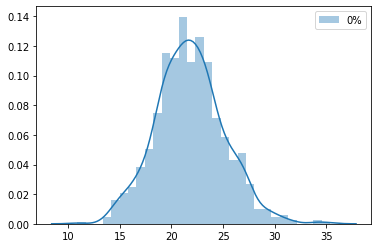

NormaltestResult(statistic=17.368571955883887, pvalue=0.00016922421981153902)
-------------------------------------------------------------------------------------


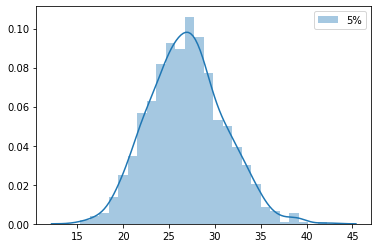

NormaltestResult(statistic=8.871519285934266, pvalue=0.011846063709857413)
-------------------------------------------------------------------------------------


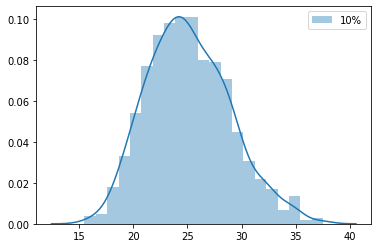

NormaltestResult(statistic=21.359674429070893, pvalue=2.3004120301511247e-05)
-------------------------------------------------------------------------------------


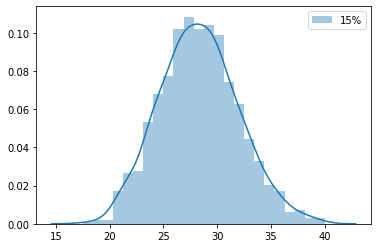

NormaltestResult(statistic=5.904749482442786, pvalue=0.05221556015660799)
-------------------------------------------------------------------------------------


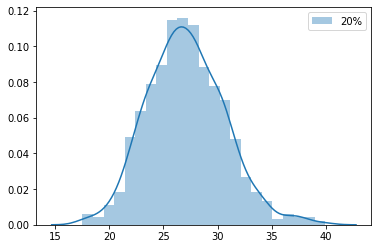

NormaltestResult(statistic=19.713978534783617, pvalue=5.2379814129527886e-05)
-------------------------------------------------------------------------------------


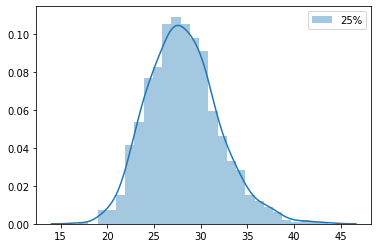

NormaltestResult(statistic=39.60789813159227, pvalue=2.5075765558866555e-09)
-------------------------------------------------------------------------------------


In [55]:
# Reviewing the distribution plots

for i in range(len(discounts)):

    sns.distplot(discounts[i], label=discount_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(discounts[i]))
    print ("-------------------------------------------------------------------------------------")

The distribution plots are now more normal than before. However, most p-values show that the groups are not normal yet. Next, I will check if the groups contain outliers by using the boxplots.

The boxplot of 0% distribution


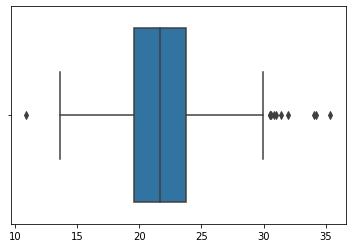

-------------------------------------------------------------------------------------
The boxplot of 5% distribution


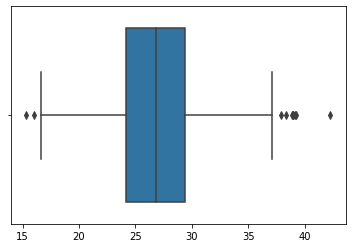

-------------------------------------------------------------------------------------
The boxplot of 10% distribution


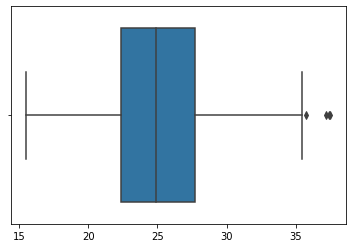

-------------------------------------------------------------------------------------
The boxplot of 15% distribution


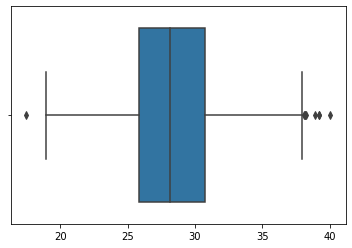

-------------------------------------------------------------------------------------
The boxplot of 20% distribution


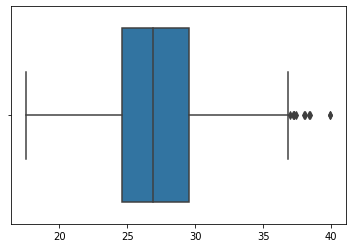

-------------------------------------------------------------------------------------
The boxplot of 25% distribution


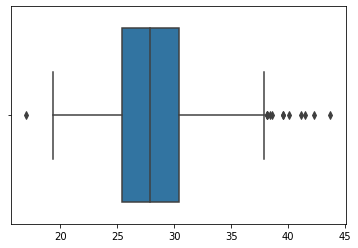

-------------------------------------------------------------------------------------


In [56]:
# Confirming that there are outliers

for i in range(len(discounts)):
    
    print('The boxplot of {} distribution'.format(discount_names[i]))
    sns.boxplot(discounts[i])
    plt.show()
    print ("-------------------------------------------------------------------------------------")

The boxplots confirm that there are outliers. So, I will remove them and review the distribution plots.

In [57]:
# Removing outliers

zero = remove_outliers(zero)
five = remove_outliers(five)
ten = remove_outliers(ten)
fifteen = remove_outliers(fifteen)
twenty = remove_outliers(twenty)
twenty_five = remove_outliers(twenty_five)

discounts = [zero, five, ten, fifteen, twenty, twenty_five]

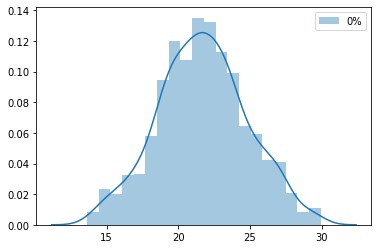

NormaltestResult(statistic=2.371451950619215, pvalue=0.3055242958721513)
-------------------------------------------------------------------------------------


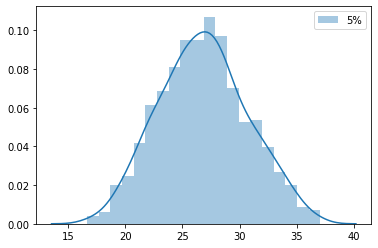

NormaltestResult(statistic=10.444936317583007, pvalue=0.005393999436181905)
-------------------------------------------------------------------------------------


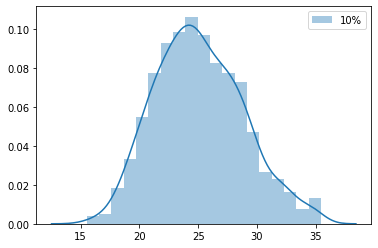

NormaltestResult(statistic=17.5217915717501, pvalue=0.0001567441364959884)
-------------------------------------------------------------------------------------


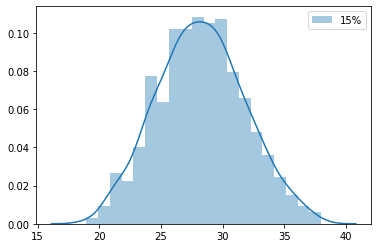

NormaltestResult(statistic=7.844454479942646, pvalue=0.019796953040411985)
-------------------------------------------------------------------------------------


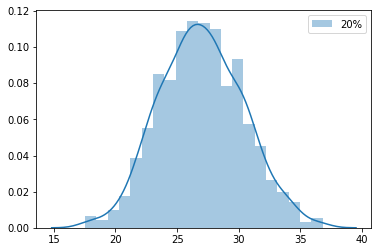

NormaltestResult(statistic=2.7592261595542587, pvalue=0.25167591272357265)
-------------------------------------------------------------------------------------


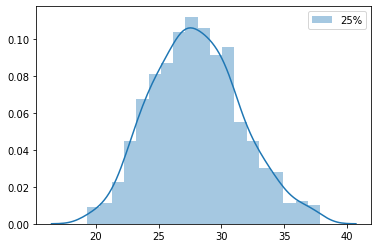

NormaltestResult(statistic=10.825498108349752, pvalue=0.004459364311444776)
-------------------------------------------------------------------------------------


In [58]:
# Reviewing the distribution plots

for i in range(len(discounts)):

    sns.distplot(discounts[i], label=discount_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(discounts[i]))
    print ("-------------------------------------------------------------------------------------")

Most p-values are still lower than the threshold value of 0.05. However, the distribution plots are quite normal now. So, we will proceed with testing. 

First, we will check if our datasets have equal or unequal variances.

In [60]:
# checking if variances are equal

st.levene(zero, five, ten, fifteen, twenty, twenty_five, center='mean')

LeveneResult(statistic=11.278696405326713, pvalue=7.599475311832316e-11)

Since the variances are unequal, we cannot use the regular t-test. We will use the Welch's t-test instead. For these tests, we will form the following one tailed hypotheses - 

$H_{0}$ : The mean difference between the quantity ordered at discount level 1 and the quantity ordered at discount level 2 is zero. ($\mu_{0} >= \mu_{1}$) 

$H_{1}$ : The mean difference between the quantity ordered at discount level 1 and the quantity ordered at discount level 2 is larger than zero.  ($\mu_{0} < \mu_{1}$)

In [61]:
# performing Welch's t-test between 0% and 5%

print(p_value(zero, five))

# checking the mean values

print('0%:', np.mean(zero))
print('5%:', np.mean(five))

0.0
0%: 21.696427367711493
5%: 26.82669362992922


The p-value is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the quantity ordered at 0% discount and the quantity ordered at 5% discount is zero.

Based on the mean values, the quantity ordered at 5% discount is higher.

In [62]:
# performing Welch's t-test between 5% and 10%

print(p_value(five, ten))

# checking the mean values

print('5%:', np.mean(five))
print('10%:', np.mean(ten))

0.0
5%: 26.82669362992922
10%: 25.08922356091031


The p-value is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the quantity ordered at 0% discount and the quantity ordered at 5% discount is zero. 

However, based on the mean values, the quantity ordered at 10% discount is less than the quantity ordered at 5%. This means that the quantity ordered at 5% discount is significantly higher than 10% and thus, providing 10% discount is not effective.

In [63]:
# performing Welch's t-test between 10% and 15%

print(p_value(ten, fifteen))

# checking the mean values

print('10%:', np.mean(ten))
print('15%:', np.mean(fifteen))

0.0
10%: 25.08922356091031
15%: 28.241641439623276


The p-value is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the quantity ordered at 10% discount and the quantity ordered at 15% discount is zero.

Based on the mean values, the quantity ordered at 15% discount is higher.

In [64]:
# performing Welch's t-test between 15% and 20%

print(p_value(fifteen, twenty))

# checking the mean values

print('15%:', np.mean(fifteen))
print('20%:', np.mean(twenty))

4.440892098500626e-16
15%: 28.241641439623276
20%: 26.977451971688573


The p-value is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the quantity ordered at 15% discount and the quantity ordered at 20% discount is zero. 

However, based on the mean values, the quantity ordered at 20% discount is less than the quantity ordered at 15%. This means that the quantity ordered at 15% discount is significantly higher than 20% and thus, providing 20% discount is not effective.

In [65]:
# performing Welch's t-test between 20% and 25%

print(p_value(twenty, twenty_five))

# checking the mean values

print('20%:', np.mean(twenty))
print('25%:', np.mean(twenty_five))

3.1139202327779e-11
20%: 26.977451971688573
25%: 28.00536980749747


The p-value is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the quantity ordered at 20% discount and the quantity ordered at 25% discount is zero.

Based on the mean values, the quantity ordered at 25% discount is higher.

As per the resulting p-values and the mean values, we can conclude that the discount percentages 5%, 15% and 25% are effective to increase the quantity ordered. However, discount percentages 10% and 20% are not effective.

Therefore, Northwind should apply the effective discount percentages to its pricing strategies.

# Hypothesis Testing - Season Vs Revenue

The second question I will answer by hypothesis testing is - 

###### Does seasonality have an impact on revenue?

Previously, I added a column called "Season" to the dataframe by dividing the order date into 4 different seasons. By using this column, I will create 4 subsets of "Revenue" data, each pertaining to a season. Next, I will test each subset against entire dataset of "Revenue". To perform this hypothesis testing, I will form the following two-tailed hypotheses for each season - 

$H_{0}$ : The mean difference between the revenue generated in all seasons and the revenue generated in the said season is zero. ($\mu_{0} = \mu_{1}$) 

$H_{1}$ : The mean difference between the revenue generated in all seasons and the revenue generated in the said season is not zero.  ($\mu_{0} \neq \mu_{1}$)


In [66]:
# Creating subsets based on season

all_seasons = df['Revenue']
spring = df[df['Season']=='Spring']['Revenue']
summer = df[df['Season']=='Summer']['Revenue']
autumn = df[df['Season']=='Autumn']['Revenue']
winter = df[df['Season']=='Winter']['Revenue']

In [67]:
# checking if the total number of each season adds up to all seasons

len(all_seasons) == len(spring) + len(summer) + len(autumn) + len(winter)

True

Now that we have various groups for testing, let's check the distribution plot of each group -

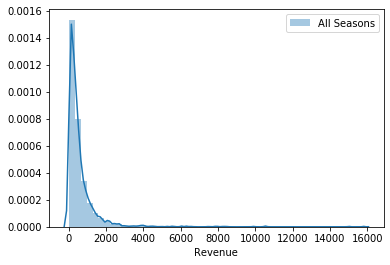

NormaltestResult(statistic=2792.290882105568, pvalue=0.0)
-------------------------------------------------------------------------------------


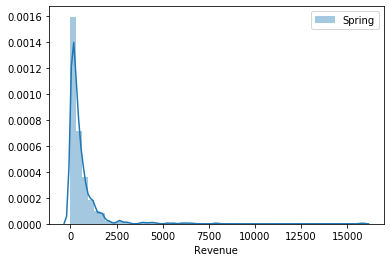

NormaltestResult(statistic=936.7120317973222, pvalue=3.9406397062549094e-204)
-------------------------------------------------------------------------------------


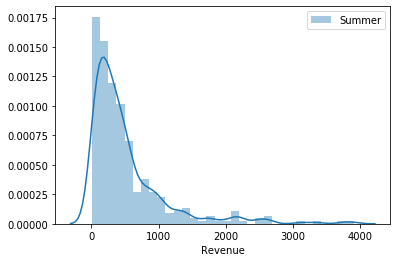

NormaltestResult(statistic=224.20197903467158, pvalue=2.066135675937331e-49)
-------------------------------------------------------------------------------------


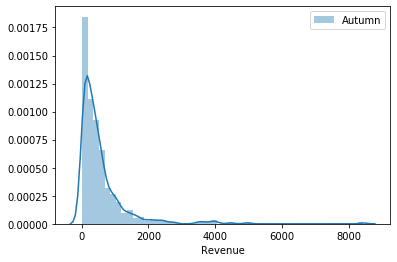

NormaltestResult(statistic=478.85730431704764, pvalue=1.0410163680049575e-104)
-------------------------------------------------------------------------------------


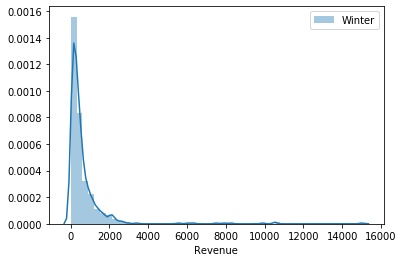

NormaltestResult(statistic=819.2095341018598, pvalue=1.290951446591121e-178)
-------------------------------------------------------------------------------------


In [68]:
# checking the distribution plots and p-values of normal test for each group

seasons = [all_seasons, spring, summer, autumn, winter]
season_names = ['All Seasons', 'Spring', 'Summer', 'Autumn', 'Winter']

for i in range(len(seasons)):

    sns.distplot(seasons[i], label=season_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(seasons[i]))
    print ("-------------------------------------------------------------------------------------")

By looking at the distribution plots and the p-values from the normal tests, we can conclude that none of the groups follow a normal distribution. Therefore, we will continue with creating sampling distribution for each group with distribution size = 1000 and sample size = 30.

In [69]:
# creating sampling distribution for each group

all_season_samples = create_sample_distribution(all_seasons, 1000, 30)
spring_sample = create_sample_distribution(spring, 1000, 30)
summer_sample = create_sample_distribution(summer, 1000, 30)
autumn_sample = create_sample_distribution(autumn, 1000, 30)
winter_sample = create_sample_distribution(winter, 1000, 30)

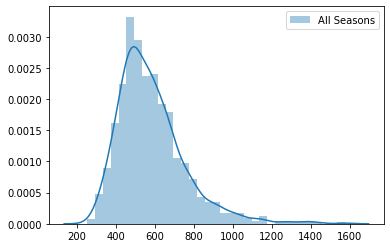

NormaltestResult(statistic=300.96788318312974, pvalue=4.422364669105399e-66)
-------------------------------------------------------------------------------------


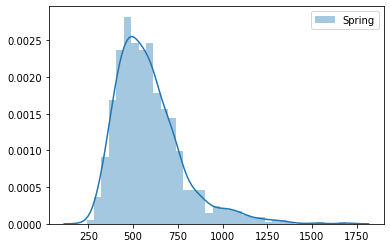

NormaltestResult(statistic=284.56244347560926, pvalue=1.614546363632569e-62)
-------------------------------------------------------------------------------------


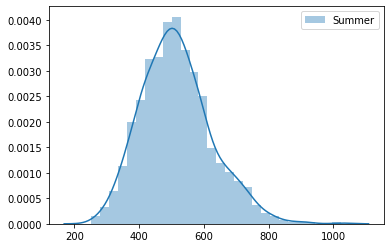

NormaltestResult(statistic=56.12052794882334, pvalue=6.51001808669594e-13)
-------------------------------------------------------------------------------------


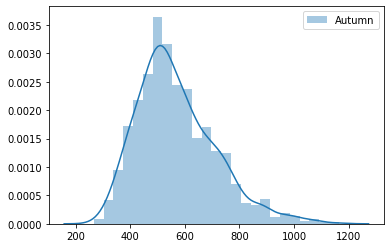

NormaltestResult(statistic=106.08317648639171, pvalue=9.211511838680959e-24)
-------------------------------------------------------------------------------------


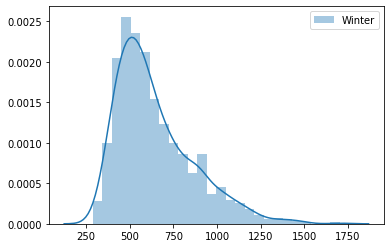

NormaltestResult(statistic=176.6094585871393, pvalue=4.4641969029862205e-39)
-------------------------------------------------------------------------------------


In [70]:
# checking the distribution plots and p-values again

seasons = [all_season_samples, spring_sample, summer_sample, autumn_sample, winter_sample]
season_names = ['All Seasons', 'Spring', 'Summer', 'Autumn', 'Winter']

for i in range(len(seasons)):

    sns.distplot(seasons[i], label=season_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(seasons[i]))
    print ("-------------------------------------------------------------------------------------")

Based on the resulting p-values, the sampling distribution are not normal. The distribution plots show that the subsets become more normal than before but they are still right skewed. This could be due to the outliers. Let's confirm this by using box plots.

The boxplot of All Seasons distribution


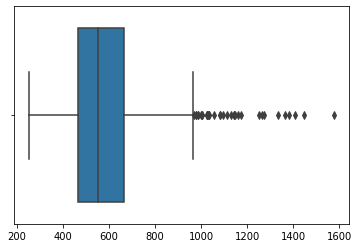

-------------------------------------------------------------------------------------
The boxplot of Spring distribution


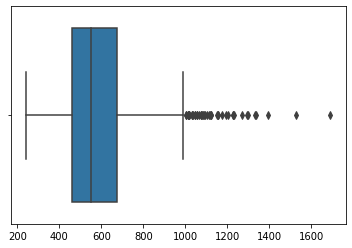

-------------------------------------------------------------------------------------
The boxplot of Summer distribution


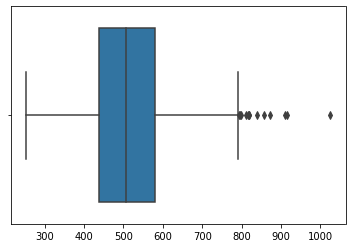

-------------------------------------------------------------------------------------
The boxplot of Autumn distribution


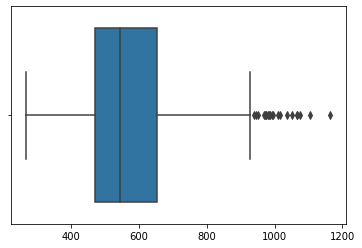

-------------------------------------------------------------------------------------
The boxplot of Winter distribution


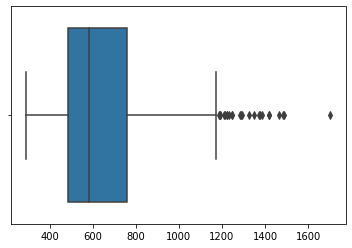

-------------------------------------------------------------------------------------


In [71]:
# Confirming that there are outliers

for i in range(len(seasons)):
    
    print('The boxplot of {} distribution'.format(season_names[i]))
    sns.boxplot(seasons[i])
    plt.show()
    print ("-------------------------------------------------------------------------------------")

The boxplots show that there are outliers in each group. Let's remove them so that they will not impact our testing.

In [72]:
# Removing outliers

all_season_samples = remove_outliers(all_season_samples)
spring_sample = remove_outliers(spring_sample)
summer_sample = remove_outliers(summer_sample)
autumn_sample = remove_outliers(autumn_sample)
winter_sample = remove_outliers(winter_sample)

seasons = [all_season_samples, spring_sample, summer_sample, autumn_sample, winter_sample]

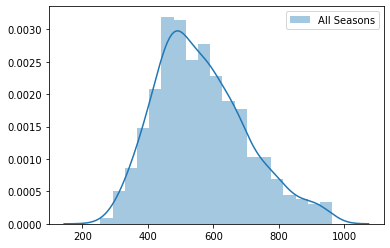

NormaltestResult(statistic=45.791158138868845, pvalue=1.1391380278733552e-10)
-------------------------------------------------------------------------------------


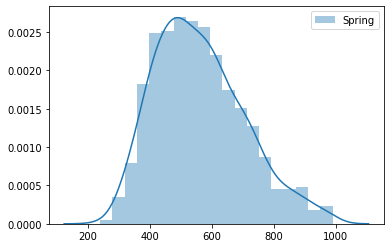

NormaltestResult(statistic=43.983178627175, pvalue=2.8130283744387567e-10)
-------------------------------------------------------------------------------------


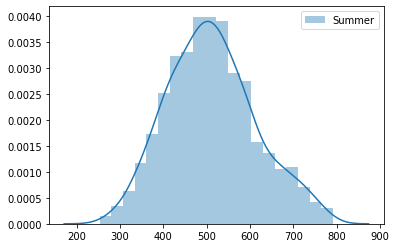

NormaltestResult(statistic=16.417697609876498, pvalue=0.00027223393533171)
-------------------------------------------------------------------------------------


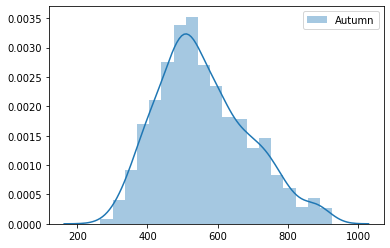

NormaltestResult(statistic=38.11184536649368, pvalue=5.298072916079432e-09)
-------------------------------------------------------------------------------------


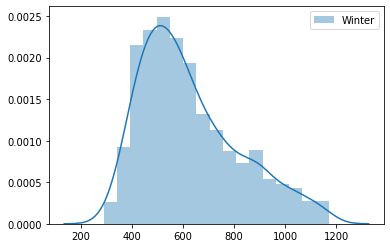

NormaltestResult(statistic=82.9056778385137, pvalue=9.937126035554237e-19)
-------------------------------------------------------------------------------------


In [73]:
# Reviewing the distribution plots

for i in range(len(seasons)):

    sns.distplot(seasons[i], label=season_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(seasons[i]))
    print ("-------------------------------------------------------------------------------------")

Next, I will check the variance of each group and see if they are equal.

In [74]:
# checking if variances are equal

st.levene(all_season_samples, spring_sample, summer_sample, autumn_sample, winter_sample, center='mean')

LeveneResult(statistic=101.03051121666554, pvalue=9.517607678385245e-83)

Since the variances of the groups are not equal, we will continue to use the Welch's t-test.

In [75]:
seasons = [spring_sample, summer_sample, autumn_sample, winter_sample]
season_names = ['Spring', 'Summer', 'Autumn', 'Winter']

for i in range(len(seasons)):
    
    print("Testing Between:{} \t{}".format('All Seasons', season_names[i]))
    print("Median Values: \ts1: {} \ts2: {}".format(round(np.median(all_season_samples), 2), round(np.median(seasons[i]), 2)))
    print("Mean Values: \ts1: {} \ts2: {}".format(round(np.mean(all_season_samples), 2), round(np.mean(seasons[i]), 2)))
    print('Sample sizes: \ts1: {} \ts2: {}'.format(len(all_season_samples), len(seasons[i])))
    print("Welch's t-test p-value:", p_value(all_season_samples, seasons[i], two_sided=True))
    print ("-------------------------------------------------------------------------------------")

Testing Between:All Seasons 	Spring
Median Values: 	s1: 546.09 	s2: 543.9
Mean Values: 	s1: 563.29 	s2: 562.0
Sample sizes: 	s1: 965 	s2: 957
Welch's t-test p-value: 0.840782919425421
-------------------------------------------------------------------------------------
Testing Between:All Seasons 	Summer
Median Values: 	s1: 546.09 	s2: 505.73
Mean Values: 	s1: 563.29 	s2: 511.2
Sample sizes: 	s1: 965 	s2: 987
Welch's t-test p-value: 0.0
-------------------------------------------------------------------------------------
Testing Between:All Seasons 	Autumn
Median Values: 	s1: 546.09 	s2: 540.14
Mean Values: 	s1: 563.29 	s2: 558.94
Sample sizes: 	s1: 965 	s2: 979
Welch's t-test p-value: 0.4727686936556488
-------------------------------------------------------------------------------------
Testing Between:All Seasons 	Winter
Median Values: 	s1: 546.09 	s2: 580.6
Mean Values: 	s1: 563.29 	s2: 626.09
Sample sizes: 	s1: 965 	s2: 975
Welch's t-test p-value: 2.220446049250313e-16
-----------

The p-values from 3 out 4 Welch's t-tests are less than the threshold value of 0.05. These p-values are for spring, summer and winter. Therefore, we can reject these seasons' null hypotheses that the mean difference between the revenue generated in that season and the revenue generated in all seasons is zero. 

The resulting p-value for autumn is greater than the threshold value of 0.05. Therefore, we cannot reject the null hypothesis that the mean difference between the revenue generated in autumn and the revenue generated in all seasons is zero. 

Since spring, summer and winter have revenues significantly different from all seasons' revenue, we can conclude that seasonality influences the revenue. 

Now, let's perform Welch's t-test between each season to find out if any season has significantly higher or lower revenue than other seasons. We will continue to use $\alpha$ or the threshold value as 0.05 in these tests. For these tests, we will form the following one-tailed hypotheses - 

$H_{0}$ : The mean difference between the revenue generated in season 1 and the revenue generated in season 2 is zero. ($\mu_{0} >= \mu_{1}$) 

$H_{1}$ : The mean difference between the revenue generated in season 1 and the revenue generated in season 2 is not zero.  ($\mu_{0} \neq \mu_{1}$)



In [76]:
# performing Welch's t-test between spring and summer

print(p_value(summer_sample, spring_sample, two_sided=True))

# checking the mean values

print('Summer:', np.mean(summer_sample))
print('Spring:', np.mean(spring_sample))

0.0
Summer: 511.20048015873016
Spring: 562.0022028909788


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in summer and revenue generated in spring is zero. Based on the mean values, more revenue generated in spring. 

In [77]:
# performing Welch's t-test between spring and autumn

print(p_value(autumn_sample, spring_sample, two_sided=True))

# checking the mean values

print('Autumn:', np.mean(autumn_sample))
print('Spring:', np.mean(spring_sample))

0.6231973810332874
Autumn: 558.9354857167177
Spring: 562.0022028909788


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in autumn and revenue generated in spring is zero. Based on the mean values, more revenue generated in spring. 

In [78]:
# performing Welch's t-test between spring and winter

print(p_value(winter_sample, spring_sample, two_sided=True))

# checking the mean values

print('Winter:', np.mean(winter_sample))
print('Spring:', np.mean(spring_sample))

4.440892098500626e-16
Winter: 626.0860481025642
Spring: 562.0022028909788


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in winter and revenue generated in spring is zero. Based on the mean values, more revenue generated in winter. 

In [79]:
# performing Welch's t-test between summer and autumn

print(p_value(autumn_sample, summer_sample, two_sided=True))

# checking the mean values

print('Autumn:', np.mean(autumn_sample))
print('Summer:', np.mean(summer_sample))

0.0
Autumn: 558.9354857167177
Summer: 511.20048015873016


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in autumn and revenue generated in summer is zero. Based on the mean values, more revenue generated in autumn. 

In [80]:
# performing Welch's t-test between summer and winter

print(p_value(winter_sample, summer_sample, two_sided=True))

# checking the mean values

print('Winter:', np.mean(winter_sample))
print('Summer:', np.mean(summer_sample))

0.0
Winter: 626.0860481025642
Summer: 511.20048015873016


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in winter and revenue generated in summer is zero. Based on the mean values, more revenue generated in winter. 

In [81]:
# performing Welch's t-test between autumn and winter

print(p_value(winter_sample, autumn_sample, two_sided=True))

# checking the mean values

print('Winter:', np.mean(winter_sample))
print('Autumn:', np.mean(autumn_sample))

0.0
Winter: 626.0860481025642
Autumn: 558.9354857167177


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in winter and revenue generated in autumn is zero. Based on the mean values, more revenue generated in winter. 

From these Welch's t-tests, we found that the revenue generated in winter is significantly higher from all other seasons. We also found that the revenue generated in summer is significantly lower from all other seasons. In addition, we also found the spring has the second and autumn has the third highest revenue which are significantly different from other seasons.

Based on these results, Northwind should focus on Winter when the most revenue is generated and find out why the sales are the lowest in summer.

# Hypothesis Testing - Region Vs Revenue

The next question we will answer via hypothesis testing is -

###### Does region of business have an impact on revenue?

As the first step, we will test the revenue generated in each region against the revenue generated in all region. To test this, we will form the following two tail hypotheses - 

$H_{0}$ : The mean difference between the revenue generated in all regions and the revenue generated in the said region is zero. ($\mu_{0} = \mu_{1}$) 

$H_{1}$ : The mean difference between the revenue generated in all regions and the revenue generated in the said region is not zero.  ($\mu_{0} \neq \mu_{1}$)

In [82]:
# Checking the unique regions

df['RegionDescription'].unique()

array(['Eastern', 'Western', 'Southern', 'Northern'], dtype=object)

In [83]:
# Dividing the revenue based on regions

all_regions = df['Revenue']
eastern = df[df['RegionDescription']=='Eastern']['Revenue']
western = df[df['RegionDescription']=='Western']['Revenue']
southern = df[df['RegionDescription']=='Southern']['Revenue']
northern = df[df['RegionDescription']=='Northern']['Revenue']

In [84]:
# Checking if all the subsets add up to the total population

len(all_regions) == len(eastern) + len(western) + len(southern) + len(northern)

True

Now that we have the subset of revenue for each region, let's check if these groups follow a normal distribution. We will check this with distribution plots and the normal tests.

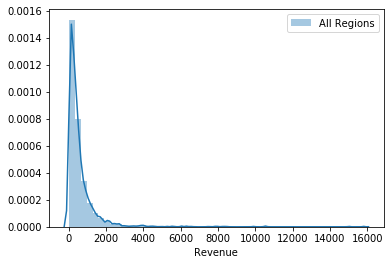

NormaltestResult(statistic=2792.290882105568, pvalue=0.0)
-------------------------------------------------------------------------------------


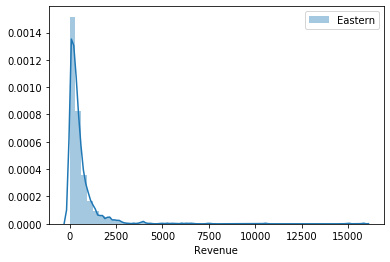

NormaltestResult(statistic=1602.6945639308594, pvalue=0.0)
-------------------------------------------------------------------------------------


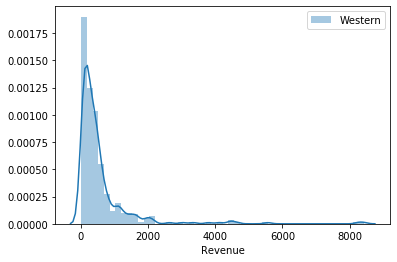

NormaltestResult(statistic=378.0179584813074, pvalue=8.21189306974285e-83)
-------------------------------------------------------------------------------------


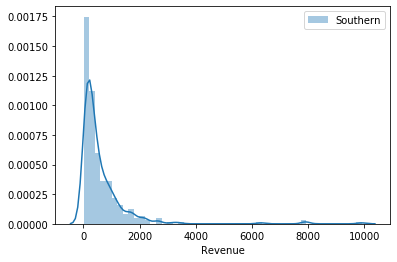

NormaltestResult(statistic=385.7238761032611, pvalue=1.7423064124120598e-84)
-------------------------------------------------------------------------------------


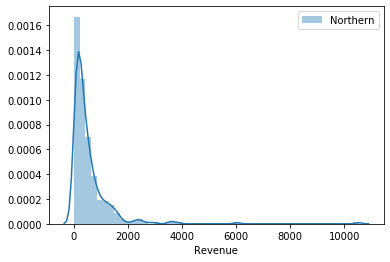

NormaltestResult(statistic=493.43873854549327, pvalue=7.098054771119215e-108)
-------------------------------------------------------------------------------------


In [85]:
regions = [all_regions, eastern, western, southern, northern]
region_names = ['All Regions', 'Eastern', 'Western', 'Southern', 'Northern']

# Checking the distribution plots

for i in range(len(regions)):

    sns.distplot(regions[i], label=region_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(regions[i]))
    print ("-------------------------------------------------------------------------------------")

Both the distribution plots and the p-values show that the distributions of our groups are far from normal. Therefore, we need to create sampling distributions to make them normal.|

In [86]:
# Creating sampling distributions

all_regions_sample = create_sample_distribution(all_regions, 1000, 30)
eastern_sample = create_sample_distribution(eastern, 1000, 30)
western_sample = create_sample_distribution(western, 1000, 30)
northern_sample = create_sample_distribution(northern, 1000, 30)
southern_sample = create_sample_distribution(southern, 1000, 30)

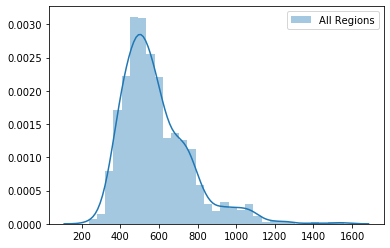

NormaltestResult(statistic=258.9463573426336, pvalue=5.895395540383956e-57)
-------------------------------------------------------------------------------------


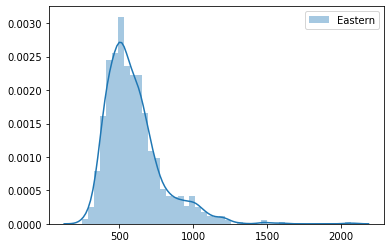

NormaltestResult(statistic=370.9266059473852, pvalue=2.84649826197347e-81)
-------------------------------------------------------------------------------------


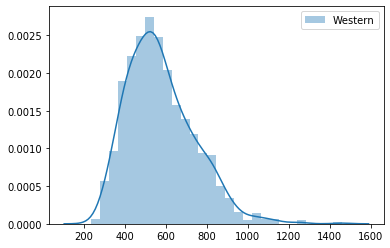

NormaltestResult(statistic=120.45334633922009, pvalue=6.980526482549837e-27)
-------------------------------------------------------------------------------------


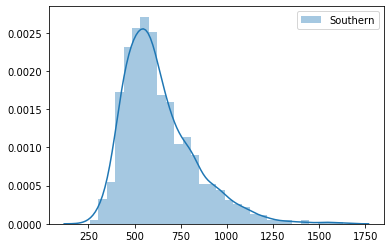

NormaltestResult(statistic=223.86378720014807, pvalue=2.44678754153275e-49)
-------------------------------------------------------------------------------------


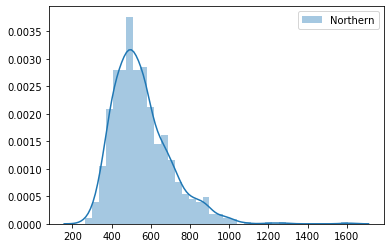

NormaltestResult(statistic=264.7509589348691, pvalue=3.236381634351214e-58)
-------------------------------------------------------------------------------------


In [87]:
regions = [all_regions_sample, eastern_sample, western_sample, southern_sample, northern_sample]
region_names = ['All Regions', 'Eastern', 'Western', 'Southern', 'Northern']

# Reviewing the distribution of all_regions

for i in range(len(regions)):

    sns.distplot(regions[i], label=region_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(regions[i]))
    print ("-------------------------------------------------------------------------------------")

Based on the resulting p-values, the sampling distribution are not normal. The distribution plots show that the subsets become more normal than before but they are still right skewed. This could be due to the outliers. Let's confirm this by using box plots.

The boxplot of All Regions distribution


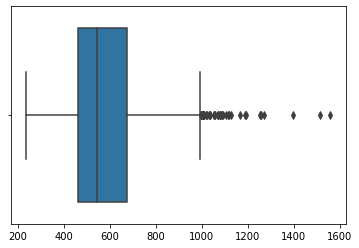

-------------------------------------------------------------------------------------
The boxplot of Eastern distribution


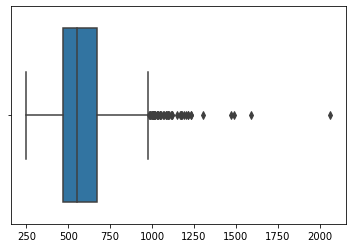

-------------------------------------------------------------------------------------
The boxplot of Western distribution


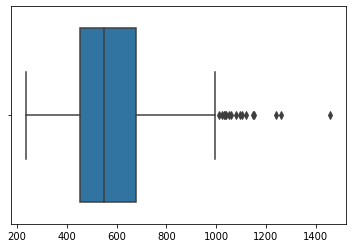

-------------------------------------------------------------------------------------
The boxplot of Southern distribution


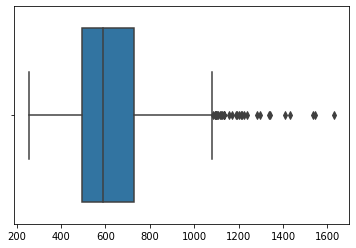

-------------------------------------------------------------------------------------
The boxplot of Northern distribution


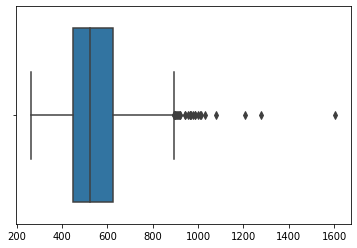

-------------------------------------------------------------------------------------


In [88]:
for i in range(len(regions)):
    
    print('The boxplot of {} distribution'.format(region_names[i]))
    sns.boxplot(regions[i])
    plt.show()
    print ("-------------------------------------------------------------------------------------")

The box plots confirm that there are outliers that can be impacting our tests. So, let's remove them and check the distributions again.

In [89]:
# removing outliers in each group

all_regions_sample = remove_outliers(all_regions_sample)
eastern_sample = remove_outliers(eastern_sample)
western_sample = remove_outliers(western_sample)
northern_sample = remove_outliers(northern_sample)
southern_sample = remove_outliers(southern_sample)

regions = [all_regions_sample, eastern_sample, western_sample, southern_sample, northern_sample]

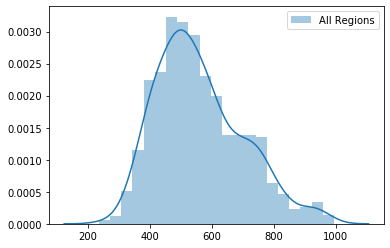

NormaltestResult(statistic=55.70248030860045, pvalue=8.023430348018741e-13)
-------------------------------------------------------------------------------------


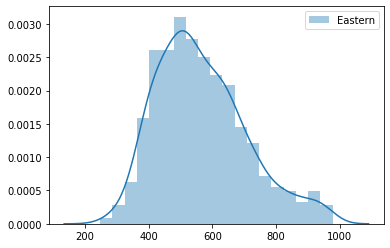

NormaltestResult(statistic=56.99214077844911, pvalue=4.2103080654065143e-13)
-------------------------------------------------------------------------------------


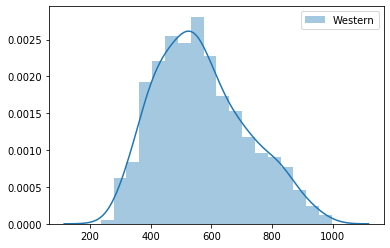

NormaltestResult(statistic=42.559233711748, pvalue=5.732972023832086e-10)
-------------------------------------------------------------------------------------


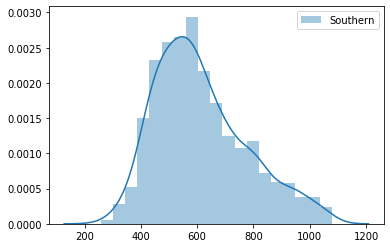

NormaltestResult(statistic=63.197057545038824, pvalue=1.8920530879329745e-14)
-------------------------------------------------------------------------------------


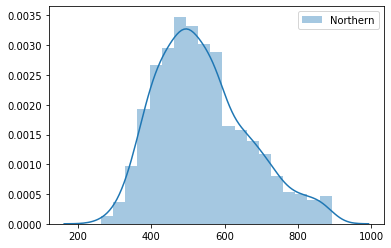

NormaltestResult(statistic=50.50251250647183, pvalue=1.0802362526841173e-11)
-------------------------------------------------------------------------------------


In [90]:
# Reviewing the distribution plots

for i in range(len(regions)):

    sns.distplot(regions[i], label=region_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(regions[i]))
    print ("-------------------------------------------------------------------------------------")

Although the p-values are still less than 0.05, the distribution plots are more or less normal now.

Next, we will check if our groups have equal variance in order to see if we should continue using the Welch's t-test.

In [91]:
# checking if variances are equal

st.levene(all_regions_sample, eastern_sample, western_sample, southern_sample, northern_sample, center='mean')

LeveneResult(statistic=16.984414516337697, pvalue=7.730077744325838e-14)

Since the variances of the groups are not equal, we will use the Welch's t-test to test between the revenue generated in each region and the revenue generated in all regions.

In [92]:
regions = [eastern_sample, western_sample, southern_sample, northern_sample]
region_names = ['Eastern', 'Western', 'Southern', 'Northern']

# Checking the Welch's t-test p-values

for i in range(len(regions)):
    
    print("Testing Between:{} \t{}".format('All Regions', region_names[i]))
    print("Median Values: \ts1: {} \ts2: {}".format(round(np.median(all_regions_sample), 2), round(np.median(regions[i]), 2)))
    print("Mean Values: \ts1: {} \ts2: {}".format(round(np.mean(all_regions_sample), 2), round(np.mean(regions[i]), 2)))
    print('Sample sizes: \ts1: {} \ts2: {}'.format(len(all_regions_sample), len(regions[i])))
    print("Welch's t-test p-value:", p_value(all_regions_sample, regions[i], two_sided=True))
    print ("-------------------------------------------------------------------------------------")

Testing Between:All Regions 	Eastern
Median Values: 	s1: 535.1 	s2: 542.69
Mean Values: 	s1: 560.91 	s2: 565.55
Sample sizes: 	s1: 959 	s2: 947
Welch's t-test p-value: 0.47315701303398816
-------------------------------------------------------------------------------------
Testing Between:All Regions 	Western
Median Values: 	s1: 535.1 	s2: 545.37
Mean Values: 	s1: 560.91 	s2: 567.37
Sample sizes: 	s1: 959 	s2: 984
Welch's t-test p-value: 0.32843878453519904
-------------------------------------------------------------------------------------
Testing Between:All Regions 	Southern
Median Values: 	s1: 535.1 	s2: 582.78
Mean Values: 	s1: 560.91 	s2: 613.28
Sample sizes: 	s1: 959 	s2: 968
Welch's t-test p-value: 6.106226635438361e-14
-------------------------------------------------------------------------------------
Testing Between:All Regions 	Northern
Median Values: 	s1: 535.1 	s2: 520.16
Mean Values: 	s1: 560.91 	s2: 539.14
Sample sizes: 	s1: 959 	s2: 973
Welch's t-test p-value: 0.0003

As per the Welch's t-tests, the p-values of eastern and western regions are more than the threshold value (0.05). Therefore, we cannot reject the null hypotheses that the mean difference between the revenue generated in all regions and the revenue generated in each of these two regions is equal to zero.

However, the p-values of northern and southern regions are less than 0.05. So, we can reject the null hyopotheses that the mean difference between the revenue generated in all regions and the revenue generated in each of these two regions is not equal to zero.

Now, let's test between each region in order to find out which regions have significantly lower or higher revenue than other regions. For these tests, We will continue to use $\alpha$ or the threshold value as 0.05. The two tailed hypotheses for these tests are as follow - 

$H_{0}$ : The mean difference between the revenue generated in region 1 and the revenue generated in region 2 is zero. ($\mu_{0} >= \mu_{1}$) 

$H_{1}$ : The mean difference between the revenue generated in region 1 and the revenue generated in region 2 is not zero.  ($\mu_{0} \neq \mu_{1}$)


In [93]:
# performing Welch's t-test between eastern and western

print(p_value(western_sample, eastern_sample, two_sided=True))

# checking the mean values

print('Western:', np.mean(western_sample))
print('Eastern:', np.mean(eastern_sample))

0.783599274842893
Western: 567.3718758807588
Eastern: 565.5451679338262


Since the p-value is higher than 0.05, we cannot reject the null hypothesis that the mean difference between the revenue generated in western region and revenue generated in eastern region is zero.

In [94]:
# performing Welch's t-test between eastern and northern

print(p_value(northern_sample, eastern_sample, two_sided=True))

# checking the mean values

print('Northern:', np.mean(northern_sample))
print('Eastern:', np.mean(eastern_sample))

1.5765456116367815e-05
Northern: 539.1352252141144
Eastern: 565.5451679338262


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in northern region and revenue generated in eastern region is not equal to zero. Based on the mean values, the revenue generated in eastern is more than northern region.

In [95]:
# performing Welch's t-test between eastern and southern

print(p_value(southern_sample, eastern_sample, two_sided=True))

# checking the mean values

print('Southern:', np.mean(southern_sample))
print('Eastern:', np.mean(eastern_sample))

9.511280651963716e-12
Southern: 613.2816836432506
Eastern: 565.5451679338262


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in southern region and revenue generated in eastern region is not equal to zero. Based on the mean values, the revenue generated in southern is more than eastern region.

In [96]:
# performing Welch's t-test between western and northern

print(p_value(northern_sample, western_sample, two_sided=True))

# checking the mean values

print('Northern:', np.mean(northern_sample))
print('Western:', np.mean(western_sample))

6.8386068075021456e-06
Northern: 539.1352252141144
Western: 567.3718758807588


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in western region and revenue generated in northern region is not equal to zero. Based on the mean values, the revenue generated in western is more than northern region.

In [97]:
# performing Welch's t-test between western and southern

print(p_value(southern_sample, western_sample, two_sided=True))

# checking the mean values

print('Southern:', np.mean(southern_sample))
print('Western:', np.mean(western_sample))

1.2790057901668206e-10
Southern: 613.2816836432506
Western: 567.3718758807588


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in western region and revenue generated in southern region is not equal to zero. Based on the mean values, the revenue generated in southern is more than western region.

In [98]:
# performing Welch's t-test between northern and southern

print(p_value(southern_sample, northern_sample))

# checking the mean values

print('Southern:', np.mean(southern_sample))
print('Northern:', np.mean(northern_sample))

0.0
Southern: 613.2816836432506
Northern: 539.1352252141144


Since the p-value is less than 0.05, we can reject the null hypothesis that the mean difference between the revenue generated in southern region and revenue generated in northern region is not equal to zero. Based on the mean values, the revenue generated in southern is more than northern region.

As per the calculated p-values and mean values, we can conclude that the revenues generated in most regions are significantly different from revenues generated in other regions except for eastern and western regions. Northern region has the lowest and the souther region has the highest revenue generated. 

Based on this analysis, Northwind should investigate why the northern region has the lowest revenue and also see if it can generate more revenue in southern region by investing more in it.

# Hypothesis Testing - Shipping Company Vs Freight Cost

The next question we will answer is - 

###### Does the choice of a shipping company have an impact on the freight cost? 

In other words, we need to find if one shipping company is cheaper than the others. To answer this, we will peform the following two tailed hypotheses - 

$H_{0}$ : The mean difference between the average freight cost of all shipping companies and the average freight cost of the said shipping company is zero. ($\mu_{0} = \mu_{1}$) 

$H_{1}$ : The mean difference between the average freight cost of all shipping companies and the average freight cost of the said shipping company is not zero.  ($\mu_{0} \neq \mu_{1}$)

First, let's find out how many shipping companies Northwind uses.

In [99]:
# Checking what are the shipping companies

df['CompanyName'].unique()


array(['Federal Shipping', 'Speedy Express', 'United Package'],
      dtype=object)

So, there are 3 shipping companies that Northwind uses. Let's divide the average frieght cost data into 3 subsets based on these companies.

In [100]:
# Dividing the avg_freight data into subsets

all_companies = df['Avg_Freight']
federal = df[df['CompanyName'] == 'Federal Shipping']['Avg_Freight']
speedy = df[df['CompanyName'] == 'Speedy Express']['Avg_Freight']
united = df[df['CompanyName'] == 'United Package']['Avg_Freight']

In [101]:
# Checking if the subset populations add up to the total population

len(all_companies) == len(federal) + len(speedy) + len(united)

True

Next, we will create distribution plots and check the normal test p-value for each group in order to see if they follow a normal distribution.

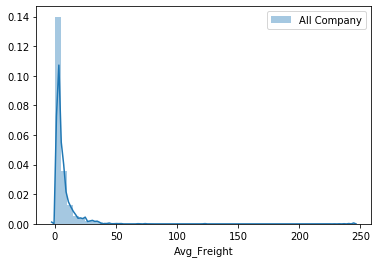

NormaltestResult(statistic=3642.8552996715334, pvalue=0.0)
-------------------------------------------------------------------------------------


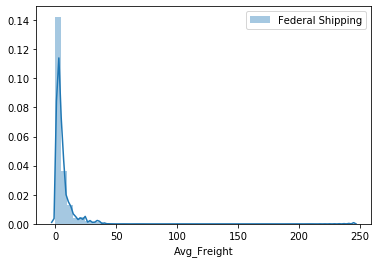

NormaltestResult(statistic=1318.604077487513, pvalue=4.664044291823046e-287)
-------------------------------------------------------------------------------------


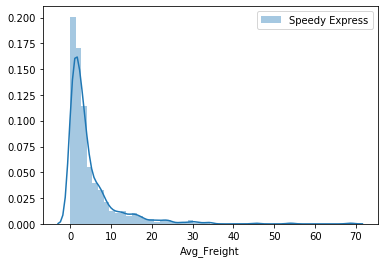

NormaltestResult(statistic=549.3819880892185, pvalue=5.049135874454914e-120)
-------------------------------------------------------------------------------------


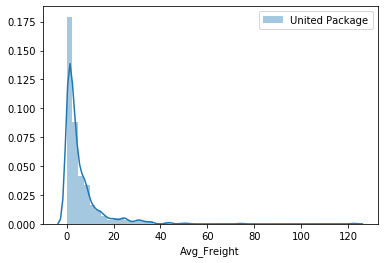

NormaltestResult(statistic=918.9177153425394, pvalue=2.881067622003755e-200)
-------------------------------------------------------------------------------------


In [102]:
companies = [all_companies, federal, speedy, united]
company_names = ['All Company', 'Federal Shipping', 'Speedy Express', 'United Package']

# Checking the distribution plots

for i in range(len(companies)):

    sns.distplot(companies[i], label=company_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(companies[i]))
    print ("-------------------------------------------------------------------------------------")

Based on the distribution plots and p-values, we know that the groups are not following a normal distribution. So, let's create a sampling distribution for each group with 1000 distribution size and 30 sample size.

In [103]:
# Creating Sampling Distributions

all_companies_sample = create_sample_distribution(all_companies, 1000, 30)
federal_sample = create_sample_distribution(federal, 1000, 30)
speedy_sample = create_sample_distribution(speedy, 1000, 30)
united_sample = create_sample_distribution(united, 1000, 30)

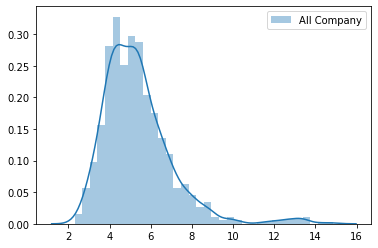

NormaltestResult(statistic=399.97571344744347, pvalue=1.4008040129765944e-87)
-------------------------------------------------------------------------------------


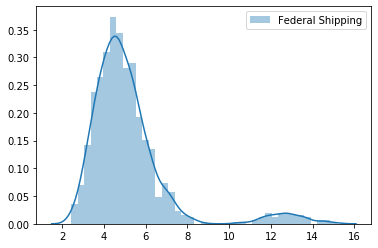

NormaltestResult(statistic=545.7898077054857, pvalue=3.042629819152577e-119)
-------------------------------------------------------------------------------------


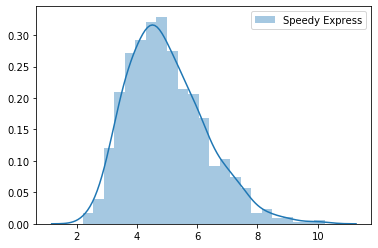

NormaltestResult(statistic=74.64861031447492, pvalue=6.169645764209788e-17)
-------------------------------------------------------------------------------------


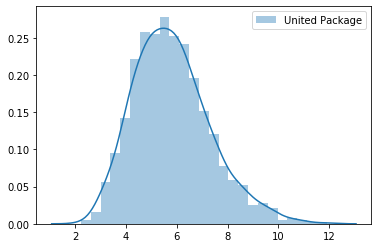

NormaltestResult(statistic=58.24813632014957, pvalue=2.2468698028055868e-13)
-------------------------------------------------------------------------------------


In [104]:
companies = [all_companies_sample, federal_sample, speedy_sample, united_sample]
company_names = ['All Company', 'Federal Shipping', 'Speedy Express', 'United Package']

# Reviewing the distribution plots

for i in range(len(companies)):

    sns.distplot(companies[i], label=company_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(companies[i]))
    print ("-------------------------------------------------------------------------------------")

The distribution plots look more than normal than before. However, they are still right skewed and the p-values are less than 0.05. This could be due to the outliers.

Let's check if the groups have outliers. 

The boxplot of All Company distribution


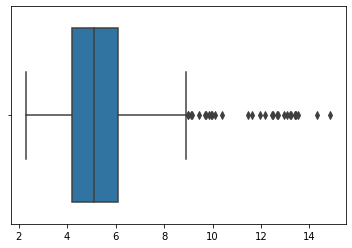

-------------------------------------------------------------------------------------
The boxplot of Federal Shipping distribution


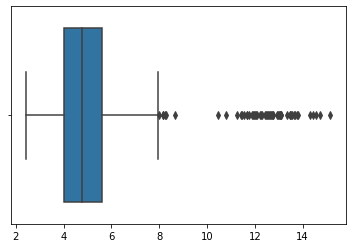

-------------------------------------------------------------------------------------
The boxplot of Speedy Express distribution


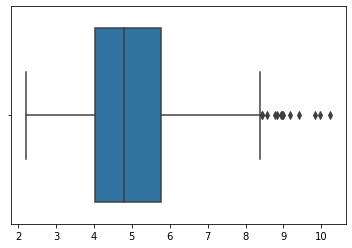

-------------------------------------------------------------------------------------
The boxplot of United Package distribution


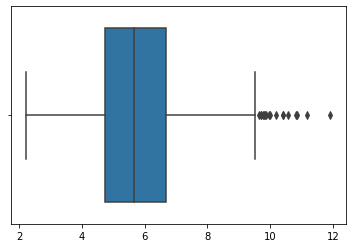

-------------------------------------------------------------------------------------


In [105]:
# Checking the box plots

for i in range(len(companies)):
    
    print('The boxplot of {} distribution'.format(company_names[i]))
    sns.boxplot(companies[i])
    plt.show()
    print ("-------------------------------------------------------------------------------------")

The boxplots confirm that the datasets contain outliers. I will remove the outliers and check the distribution plots and normal test p-values again.

In [106]:
# Removing outliers from each group

all_companies_sample = remove_outliers(all_companies_sample)
federal_sample = remove_outliers(federal_sample)
speedy_sample = remove_outliers(speedy_sample)
united_sample = remove_outliers(united_sample)

companies = [all_companies_sample, federal_sample, speedy_sample, united_sample]


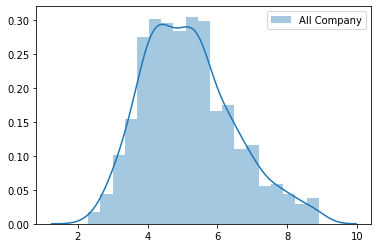

NormaltestResult(statistic=42.17163239126642, pvalue=6.958992682229353e-10)
-------------------------------------------------------------------------------------


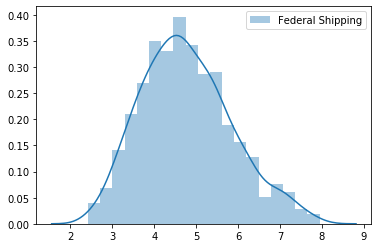

NormaltestResult(statistic=25.281484944220438, pvalue=3.237392059756379e-06)
-------------------------------------------------------------------------------------


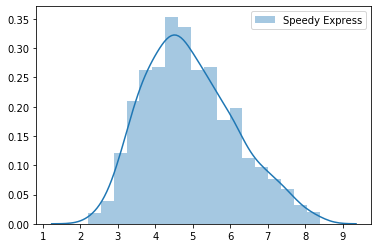

NormaltestResult(statistic=35.09870665361905, pvalue=2.3900813837522187e-08)
-------------------------------------------------------------------------------------


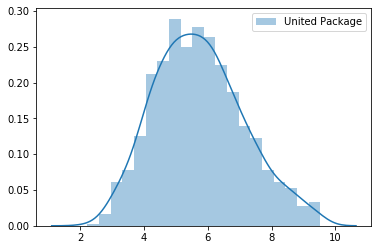

NormaltestResult(statistic=21.588291936924694, pvalue=2.0519272972850474e-05)
-------------------------------------------------------------------------------------


In [107]:
# Reviewing the distribution plots

for i in range(len(companies)):

    sns.distplot(companies[i], label=company_names[i])
    plt.legend()
    plt.show()
    print(st.normaltest(companies[i]))
    print ("-------------------------------------------------------------------------------------")

Although the normal test p-values are still less than 0.05, the distribution plots are more normal now. The long right tails have been removed as well.

Next step is check the equal variance assumption.

In [108]:
# checking the variance of each group

st.levene(all_companies_sample, federal_sample, speedy_sample, united_sample, center='mean')

LeveneResult(statistic=21.4090666790328, pvalue=9.469195405592596e-14)

Since the variances are not equal, we will continue using the Welch's t-test.

In [109]:
companies = [federal_sample, speedy_sample, united_sample]
company_names = ['Federal Shipping', 'Speedy Express', 'United Package']

# Checking the Welch's t-test p-values

for i in range(len(companies)):
    
    print("Testing Between:{} \t{}".format('All Companies', company_names[i]))
    print("Median Values: \ts1: {} \ts2: {}".format(round(np.median(all_companies_sample), 2), round(np.median(companies[i]), 2)))
    print("Mean Values: \ts1: {} \ts2: {}".format(round(np.mean(all_companies_sample), 2), round(np.mean(companies[i]), 2)))
    print('Sample sizes: \ts1: {} \ts2: {}'.format(len(all_companies_sample), len(companies[i])))
    print("Welch's t-test p-value:", p_value(all_companies_sample, companies[i], two_sided=True))
    print ("-------------------------------------------------------------------------------------")

Testing Between:All Companies 	Federal Shipping
Median Values: 	s1: 5.07 	s2: 4.67
Mean Values: 	s1: 5.17 	s2: 4.77
Sample sizes: 	s1: 970 	s2: 945
Welch's t-test p-value: 5.3179682879545e-13
-------------------------------------------------------------------------------------
Testing Between:All Companies 	Speedy Express
Median Values: 	s1: 5.07 	s2: 4.78
Mean Values: 	s1: 5.17 	s2: 4.93
Sample sizes: 	s1: 970 	s2: 987
Welch's t-test p-value: 3.7653123706959946e-05
-------------------------------------------------------------------------------------
Testing Between:All Companies 	United Package
Median Values: 	s1: 5.07 	s2: 5.63
Mean Values: 	s1: 5.17 	s2: 5.73
Sample sizes: 	s1: 970 	s2: 983
Welch's t-test p-value: 0.0
-------------------------------------------------------------------------------------


All 3 resulting p-values are less than the threshold value of 0.05. Therefore, we can reject the null hypothesis that the mean difference between the average freight cost of all shipping companies and the average freight cost of the said shipping company is zero. In other words, the choice of the shipping company has an impact on the average freight cost.

Now, let's test between each shipping company and check which companies are pricier than others. We will use the following two tailed hypotheses for these tests - 


$H_{0}$ : The mean difference between the average freight cost of company 1 and the average freight cost of company 2 is zero. ($\mu_{0} >= \mu_{1}$) 

$H_{1}$ : The mean difference between the average freight cost of company 1 and the average freight cost of company 2 is not zero.   ($\mu_{0} \neq \mu_{1}$)

In [110]:
# performing Welch's t-test between federal and speedy

print(p_value(speedy_sample, federal_sample, two_sided=True))

# checking the mean values

print('Speedy Express:', np.mean(speedy_sample))
print('Federal Shipping:', np.mean(federal_sample))

0.0019212293550658899
Speedy Express: 4.934222182641561
Federal Shipping: 4.772317883385848


The p-value between Speedy Express and Federal Shipping is larger than 0.05. Therefore, we cannot reject the null hypothesis that the mean difference between the average freight cost of Speedy Express and the average freight cost of Federal Shipping is zero.

In [111]:
# performing Welch's t-test between federal and united

print(p_value(united_sample, federal_sample, two_sided=True))

# checking the mean values

print('United Package:', np.mean(united_sample))
print('Federal Shipping:', np.mean(federal_sample))

0.0
United Package: 5.730550809256569
Federal Shipping: 4.772317883385848


The p-value between United Package and Federal Shipping is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the average freight cost of United Package and the average freight cost of Federal Shipping is zero.

By looking at the mean values, United Package has significantly more average freight cost than Federal Shipping.

In [112]:
# performing Welch's t-test between speedy and united

print(p_value(united_sample, speedy_sample, two_sided=True))

# checking the mean values

print('United Package:', np.mean(united_sample))
print('Speedy Express:', np.mean(speedy_sample))

0.0
United Package: 5.730550809256569
Speedy Express: 4.934222182641561


The p-value between United Package and Speedy Express is less than 0.05. Therefore, we can reject the null hypothesis that the mean difference between the average freight cost of United Package and the average freight cost of Speedy Express is zero.

By looking at the mean values, United Package has significantly more average freight cost than Speedy Express.

Based on these results, we can conclude that United Package has the highest average freight cost. Northwind might save costs and generate more profit by shipping more products with Federal Shipping and Speedy Express than with United Package.

# Conclusion

By performing hypothesis testing, we were able to answer the questions that were presented in the beginning of this projects. These answers will be useful for Northwind to modify several areas of its business in order to generate more revenue or save costs.

###### Does discount increase the quantity of product in an order?

Discount does increase the quantity of product ordered but not all discount percentages are effective. 5%, 15% and 25% are shown to be effective but 10% and 20% are not effective. Therefore, Northwind should utilize the effective discount percentages in order to increase the quantity ordered by its customers.

###### Does seasonality have an impact on revenue?

Seasonality has an impact on revenue. Northwind generates the highest revenue in winter months and the lowest in summer months. Therefore, Northwind should find out what strategies it could implement to increase its summer revenue. Northwind should also check if it should focus its business efforts in to winter months in order to further increase the revenue.

###### Does region of business have an impact on revenue?

Region of business has an impact on revenue. We found that the northern region has the lowest whereas the southern region has the highest revenue. Thus, Northwind should focus more on the northern region and find out what is the causing the low revenue. It should also check if it can generate more revenue in the southern region by investing in it.

###### Does the choice of shipping company have an impact on the freight cost? 

The choice of a shipping company have an impact on the freight cost. We found that, out of three shipping companies, United Package is the most expensive in terms of freight cost per product. Therefore, Northwind should see if it can ship more products with the other two companies, Federal Shipping and Speedy Express, in order to save shipping expenses.